# Face Recognition Using Siamese Network

Note: this notebook is adapted from (from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

We can better understand siamese networks by building such a system for  face recognition. 
The objective of this network is to measure how two faces are similar or dissimilar. 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd drive/My\ Drive/Colab\ Notebooks/Biometrics/Assignment3b
# pwd

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/Biometrics/Assignment3b'
/content/drive/My Drive/Colab Notebooks/Biometrics/Assignment3b


## import required packages

In [0]:
import numpy as np
import numpy.random as rng

from pathlib import Path

import os
import matplotlib.pyplot as plt
%matplotlib inline

# to be used with the plaidml backend 
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
# import plaidml.keras
# plaidml.keras.install_backend()

os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
import tensorflow as tf

from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import RMSprop

from keras.layers import Dropout, Conv2D, Convolution2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# local routine for loading images
from localmodules.datasets import load_faces, get_dimensions, get_siamese_paired_data
# local routine for constructing siamese network
from localmodules.models import create_siamese_model, contrastive_loss, accuracy


#### Import face image data sets (Olivetti (AT&T), Labeled Faces in the Wild, Caltech)

This is similar to the EigenFaces assignment import module

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [0]:
# path to dataset for Caltech data
caltechDataset = Path("../CalTechFacesDirs")

# type of database (ATT/LFW/CALTECH)
facesDB = "CALTECH"

# max number of persons to extract from database
max_persons = None

In [0]:
# Download the data, if not already on disk and load it as numpy arrays
if facesDB == "ATT":
    faces = load_faces("ATT", dataset = None, min_faces=10, max_targets=max_persons)
elif facesDB == "LFW": 
    faces = load_faces("LFW", dataset = None, min_faces=10, max_targets=max_persons)
elif facesDB == "CALTECH":
    faces = load_faces("CALTECH", dataset = caltechDataset, min_faces=10, max_targets=max_persons)
    # convert string label to unique numeric id
    y = faces.target
    # encode the labels to integers
    le = LabelEncoder()
    faces.target = le.fit_transform(y)



## Print statistics of data set

In [0]:
n_samples, n_examples, n_classes, n_features, height, width, channels = get_dimensions(faces)
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_examples: %d" % n_examples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("width: %d" % width)
print("height: %d" % height)
print("channels: %d" % channels)

faces.images.shape

Total dataset size:
n_samples: 445
n_examples: 17
n_features: 2914
n_classes: 26
width: 47
height: 62
channels: 1


(445, 62, 47)

## Construct siamese set from initial set.

The siamese set contains pairs of images that are labeled as either imposter (label 1) or genuine (label 0).

*N_siamese* is the number of such pairs you generate.

See the localmodules.dataset file for details how they are generated

In [0]:
N_siamese = 10000 # max can be n_samples**2
X, y = get_siamese_paired_data(faces, N_siamese)

In [0]:
X.shape

(20000, 2, 62, 47, 1)

In [0]:
y.shape

(20000,)

## Split in training and test set

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle = False)

In [0]:
print(x_train.shape, x_test.shape)

(15000, 2, 62, 47, 1) (5000, 2, 62, 47, 1)


Verify by random sampling if genuine and imposter pairs are correctly constructed

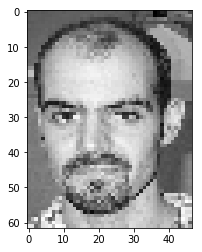

In [0]:
subj_nr = 1000

plt.imshow(np.squeeze(x_train[subj_nr,0]),cmap='gray');  

0.0

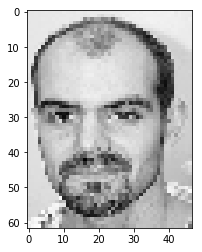

In [0]:
plt.imshow(np.squeeze(x_train[subj_nr,1]),cmap='gray'); 
y_train[subj_nr]

## Simple CNN Model

The localmodules.models file contains the description of a shallow CNN model that is trained with [contrastive loss] (https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf). 
A contrastive energy function which contained dual terms to decrease the energy of like pairs and increase the energy of unlike pairs.

This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1).

The network itself outputs the ED betweeen pairs of embedded representations (right before the distance calculation). Use this distance measure for verification and identification tests.

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [0]:
model = create_siamese_model(x_train.shape[2:])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 62, 47, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 62, 47, 1)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          1222080     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           sequential_2[1][0]         

Print the network graph

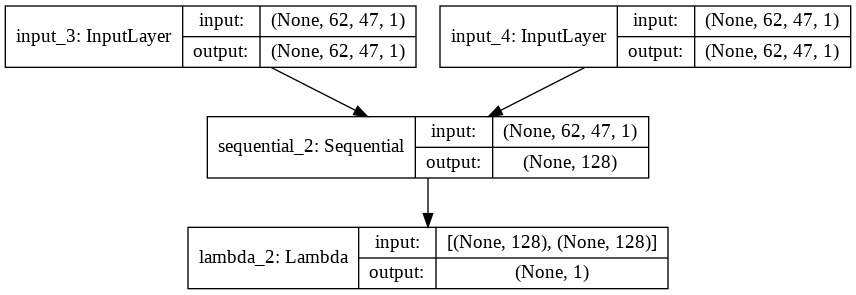

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', 
           show_shapes = True, show_layer_names = True)

from IPython.display import Image
Image(retina=True, filename='model.png')

The network will be trained with contrastive loss as objective function and Adam optimizer. It outputs an additional accuracay measure (which uses an arbitrarily set threshold = 0.5). The threshold can be determined later on through e.g. max F1-score

In [0]:
from keras.optimizers import RMSprop

rms = Adam()
model.compile(loss=contrastive_loss, optimizer=rms, metrics = ['accuracy'])

### Fit/train the model. 

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance


In [0]:
epochs = 2
model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
          validation_split=.25,
          batch_size=64, verbose=2, epochs=epochs)

W0831 23:34:26.568220 139961645848448 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0831 23:34:26.746773 139961645848448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0831 23:34:26.852047 139961645848448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 11250 samples, validate on 3750 samples
Epoch 1/2
 - 256s - loss: 0.0286 - acc: 0.9322 - val_loss: 0.0873 - val_acc: 0.6379
Epoch 2/2
 - 256s - loss: 0.0117 - acc: 0.9612 - val_loss: 0.0346 - val_acc: 0.6149


### For further testing it might be worthwhile saving a time-consuming trained network

In [0]:
model.save("siamese_nn_128_64.h5")

### Apply the network to the test data

In [0]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [0]:
pred

array([[1.3053924],
       [1.662148 ],
       [1.0930641],
       ...,
       [1.4391108],
       [1.4630299],
       [1.927055 ]], dtype=float32)

### Calculate accuracy (for an arbitrary threshold of the distance set at 0.5)

In [0]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() > 0.5].sum()/len(predictions.ravel())

In [0]:
compute_accuracy(pred, y_test)

0.9008

### Calculate pairwise distances for further analysis

In [0]:
from localmodules.distance import L2_distance
from tqdm import tqdm_notebook
import numpy.random as rng

distances = [] # distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = int(n_samples/2)
samples = rng.choice(n_samples,size=num,replace=False)

# num = n_samples
I = np.zeros((num, num))

for i in tqdm_notebook(range(num-1)):
    for j in range(i, num):
        # Euclidean norm as distance
        imgi = np.expand_dims(faces.images[i], axis = 0)
        imgi = np.expand_dims(imgi, axis = 3)

        imgj = np.expand_dims(faces.images[j], axis = 0)
        imgj = np.expand_dims(imgj, axis = 3)

        distances.append(model.predict([imgi, imgj])[0][0])
        if faces.target[i] == faces.target[j]:
            identical.append(True)
            I[i,j] =  I[j,i] = 1
        else:
            identical.append(False)
        
distances = np.array(distances)
# convert to normalized [0,1] score (the higher the better)
scores = (distances.max() - distances)/distances.max()
identical = np.array(identical)

### Compute accuracy and F1 scores for different thresholds

From here on, you can apply the same techniques as fot PCA/LBP based face recognition


In [0]:
from sklearn.metrics import f1_score, accuracy_score

# set threshold range - list of 50 values from 0.0 to 1.0
thresholds = np.linspace(0.0, 1.0, 50,dtype=list, endpoint=False).tolist()

len_t = len(thresholds)
len_s = len(scores)

f1 = np.zeros(len_t)
acc = np.zeros(len_t)

for i in range(len_t):
    pred_scores=[]
    for j in range(len_s):
        if scores[j] < thresholds[i]: #anything below threshold is considered not matching
            pred_scores.append(0)
            
        elif scores[j] >= thresholds[i]: #anything equal or greater than threshold is considered as truely identical
            pred_scores.append(1)
    f1[i] = f1_score(identical,pred_scores)
    acc[i] = accuracy_score(identical,pred_scores)


In [0]:
# Determine optimal Threshold 
opt_thresh = thresholds[np.where(f1 == np.amax(f1))[0][0]]
opt_f1 = f1[np.where(f1 == np.amax(f1))[0][0]]
# print(opt_thresh, opt_f1)

0.9 0.6518600777345919


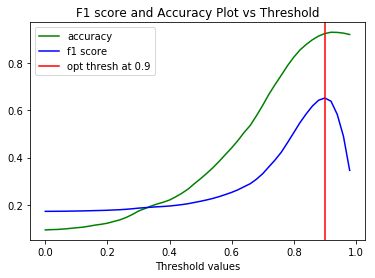

In [0]:
# Plot F1 score and accuracy as function of distance threshold
def plot_f1_acc(f1,acc,thresh):
    plt.plot(thresh, acc, 'g',label='accuracy') # plotting t, a separately 
    plt.plot(thresh, f1, 'b',label='f1 score') # plotting t, b separately 
    plt.axvline(x=opt_thresh,c='r',label='opt thresh at {}'.format(opt_thresh))
    plt.title("F1 score and Accuracy Plot vs Threshold")
    plt.xlabel("Threshold values")
    plt.legend(loc='upper left')
    plt.show()
    
plot_f1_acc(f1,acc,thresholds)

### Plot genuine and imposter scores

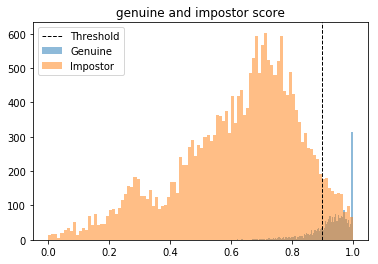

In [0]:
gen=[]
imp=[]

for k in range(len_s):
    if identical[k]==1:
        gen.append(scores[k])
    else:
        imp.append(scores[k])

plt.hist(gen, bins=100,alpha=0.5)
plt.hist(imp, bins=100,alpha=0.5)
plt.axvline(opt_thresh, color='k', linestyle='dashed', linewidth=1)
plt.legend(['Threshold','Genuine', 'Impostor'])
plt.title('genuine and impostor score')
plt.show()

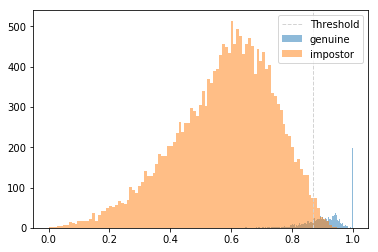

In [0]:
# DO NOT DELETE (GIVEN - for comparison)

#### EER and ROC curve

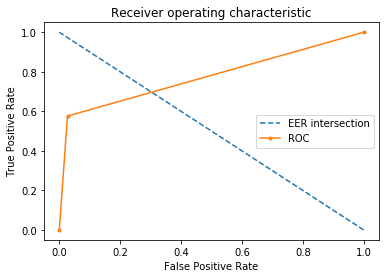

Area under the ROC curve =  0.7745451087100336
EER =  0.3969803057419516
fpr = 0.02696473841899055
tpr = 0.5760549558390579


In [0]:
# EER
from sklearn.metrics import roc_curve, auc

pred_scores = np.zeros(len_s)

for k in range(len_s):
    if scores[k] > opt_thresh:
        pred_scores[k]=1        
    else:
        pred_scores[k]=0
        
fpr, tpr, thresholds = roc_curve(pred_scores, identical, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot([1, 0],[0, 1], linestyle='--',label='EER intersection')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='right')

# show the plot
plt.show()
print('Area under the ROC curve = ', roc_auc)

fnr = 1 - tpr
eer_threshold = (np.absolute(fnr[1]- fpr[1]))
print('EER = ', eer_threshold)
print('fpr =', fpr[1])
print('tpr =', tpr[1])

#### Caluclate classification scores
* plot precision-recall curve
* calculate AUC
* average precision

Average precision-recall score: 0.48


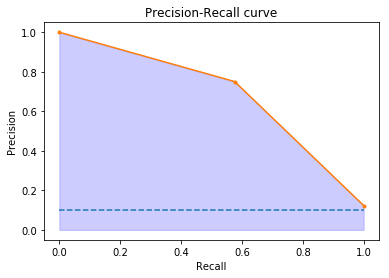

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(pred_scores, identical)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))
precision, recall, thresholds = precision_recall_curve(pred_scores, identical)

# plot  precision recall curve
plt.plot([0, 1], [0.1, 0.1], linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.plot(recall, precision, marker='.')
plt.fill_between(recall, precision, alpha=0.2, color='b')


auc=0.868 ap=0.869


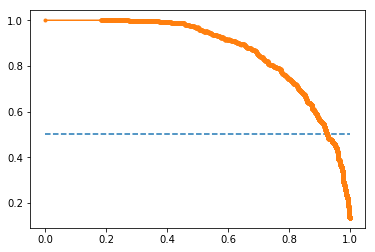

In [0]:
## DO NOT DELETE (For comparison)
